In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [12]:
trainset = datasets.CIFAR10('CIFAR10_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True)

testset = datasets.CIFAR10('CIFAR10_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
#a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images 
#containing one of 10 object classes, with 6000 images per class.

print(len(trainset))
#indexs = list(range(len(trainset)))
#print(len(indexs))
#print(indexs[0:2])

print(len(testset))

50000
10000


In [14]:
from torch import nn, optim
import torch.nn.functional as F

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim = 1)
        return x
    
model = Model()
print(model)

Model(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [16]:
#images, labels = next(iter(trainloader))
images, labels = next(iter(testloader))
ps = torch.exp(model(images))
print(ps.shape)

top_p, top_class = ps.topk(1, dim = 1)
#print(top_class[:10, :])

torch.Size([16, 10])


In [17]:
equals = top_class == labels.view(*top_class.shape)
#print(equals)
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy : {accuracy.item()*100}")

Accuracy : 6.25


In [25]:
model = Model()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epoches = 2
steps = 0
train_losses, test_losses = [], []
for i in range(epoches):
    loss1 = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion (log_ps, labels)
        loss.backward()
        optimizer.step()
        
        loss1 += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, lables in testloader:
                log_ps = model(images)
                test_loss += criterion (log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        model.train()
        
        train_losses.append(loss1 / len(trainloader))
        test_losses.append(loss1 / len(testloader))
        
        a = (loss1 / len(trainloader)) 
        b = (loss1 / len(testloader)) 
        c = (accuracy / len(testloader)) * 100
        print("Epoch {}/{}.. ".format(i+1, epoches),
             "training_loss : {:.3f}.. ".format(a),
              "testing_loss : {:.3f}.. ".format(b),
              "test_accuracy : {:.3f}.. ".format(c))

Epoch 1/2..  training_loss : 2.056..  testing_loss : 10.279..  test_accuracy : 12.530.. 
Epoch 2/2..  training_loss : 2.034..  testing_loss : 10.171..  test_accuracy : 6.750.. 


In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

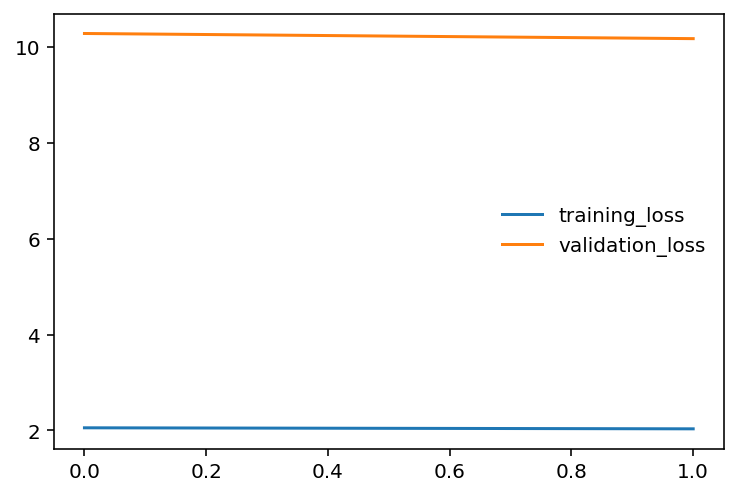

In [27]:
plt.plot(train_losses, label = "training_loss")
plt.plot(test_losses, label = "validation_loss")
plt.legend(frameon = False)